[*********************100%***********************]  1 of 1 completed


Successfully downloaded 3730 days of data

Data Quality Report:
--------------------------------------------------
Date Range: 2010-01-04 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Total Trading Days: 3730

Missing Values:
Price      Ticker
Adj Close  SB=F      0
Close      SB=F      0
High       SB=F      0
Low        SB=F      0
Open       SB=F      0
Volume     SB=F      0
dtype: int64

Basic Statistics:
Price     Adj Close        Close         High          Low         Open  \
Ticker         SB=F         SB=F         SB=F         SB=F         SB=F   
count   3730.000000  3730.000000  3730.000000  3730.000000  3730.000000   
mean      18.013968    18.013968    18.276464    17.770005    18.028402   
std        4.962443     4.962443     5.066151     4.855724     4.966137   
min        9.210000     9.210000     9.440000     9.050000     9.210000   
25%       14.130000    14.130000    14.350000    13.910000    14.120000   
50%       17.549999    17.549999    17.780001    17.355000    1

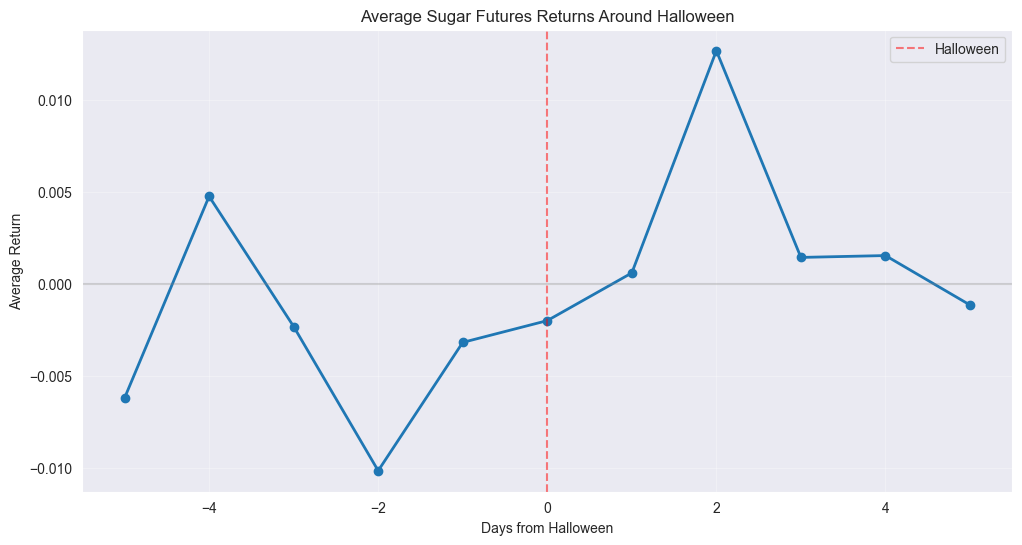

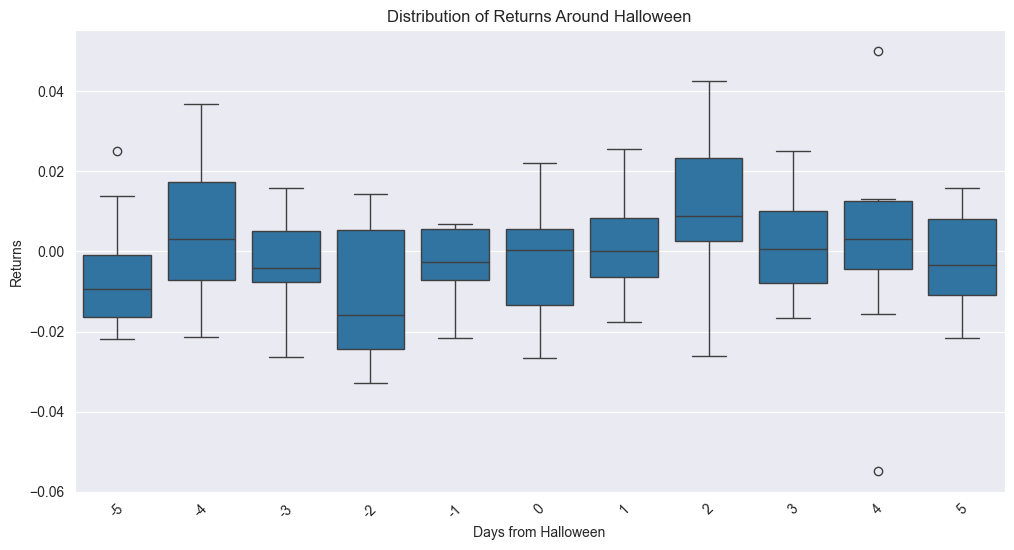

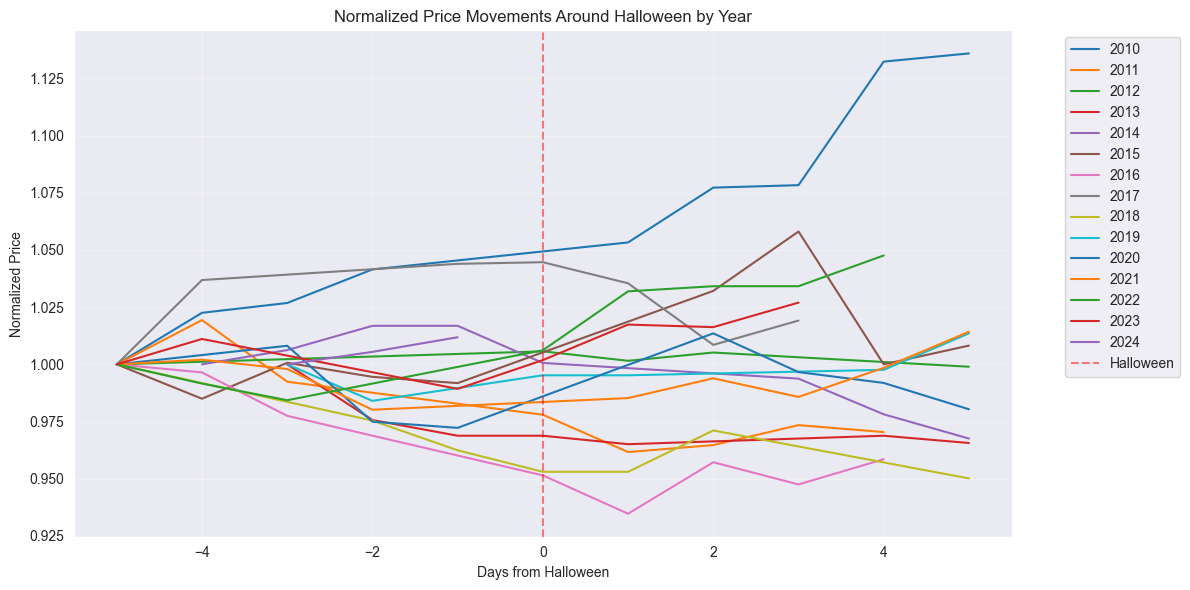


Halloween Effect Analysis Results
--------------------------------------------------
Pre-Halloween Average Return:  -0.3325%
Halloween Day Average Return:  -0.1997%
Post-Halloween Average Return: 0.3246%

Statistical Tests:
T-statistic: -1.9960
P-value: 0.0487

Interpretation:
There is a statistically significant difference between pre- and post-Halloween returns


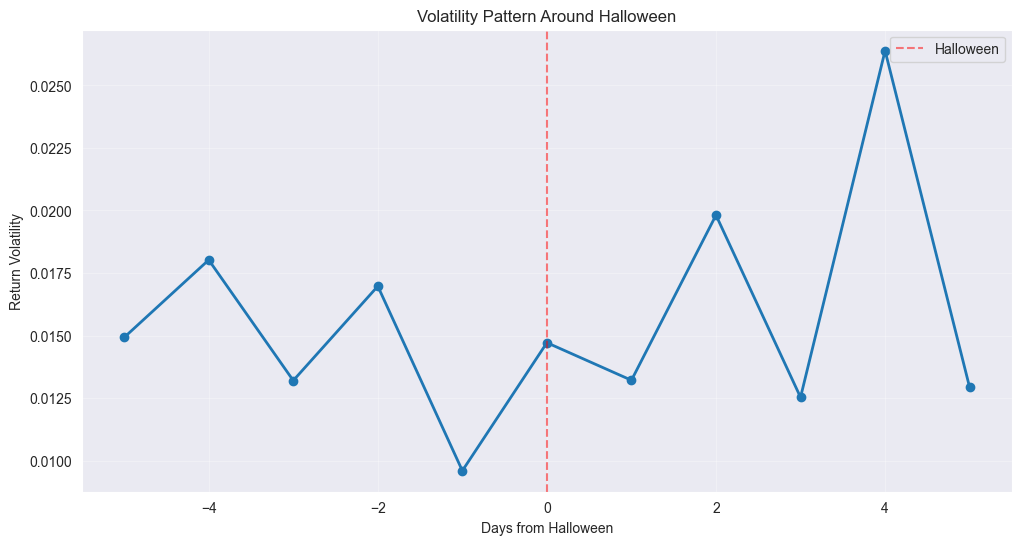


Volatility Analysis:
--------------------------------------------------
Pre-Halloween Volatility:  1.5058%
Post-Halloween Volatility: 1.7876%


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [17]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import pytz
import warnings
warnings.filterwarnings('ignore')

### 1. Data Collection
def get_sugar_futures_data(start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetch Sugar Futures data from Yahoo Finance
    Using SB=F (Sugar #11 Futures)
    """
    try:
        # Download data
        sugar = yf.download('SB=F', start=start_date, end=end_date)
        print(f"Successfully downloaded {len(sugar)} days of data")
        return sugar
    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return pd.DataFrame()

### 2. Data Quality Checks
def check_data_quality(df: pd.DataFrame) -> None:
    """
    Perform comprehensive data quality checks
    """
    print("\nData Quality Report:")
    print("-" * 50)
    print(f"Date Range: {df.index.min()} to {df.index.max()}")
    print(f"Total Trading Days: {len(df)}")
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nBasic Statistics:")
    print(df.describe())

### 3. Halloween Period Analysis
def isolate_halloween_periods(df: pd.DataFrame, window_days: int = 5) -> pd.DataFrame:
    """
    Extract trading days around Halloween (Oct 31) for analysis
    """
    halloween_periods = []
    
    # Ensure index is tz-aware
    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    
    for year in df.index.year.unique():
        # Create tz-aware Halloween timestamp
        halloween = pd.Timestamp(f'{year}-10-31').tz_localize('UTC')
        start_date = halloween - timedelta(days=window_days)
        end_date = halloween + timedelta(days=window_days)
        
        # Get the period
        period = df.loc[start_date:end_date].copy()
        if not period.empty:
            period['Year'] = year
            period['Days_To_Halloween'] = (period.index.tz_localize(None) - 
                                         halloween.tz_localize(None)).days
            halloween_periods.append(period)
    
    if halloween_periods:
        return pd.concat(halloween_periods)
    return pd.DataFrame()

### 4. Analysis Functions
def analyze_halloween_effect(df: pd.DataFrame) -> dict:
    """
    Perform statistical analysis of the Halloween effect
    """
    # Separate pre and post Halloween returns
    pre_halloween = df[df['Days_To_Halloween'] < 0]['Returns']
    post_halloween = df[df['Days_To_Halloween'] > 0]['Returns']
    halloween_day = df[df['Days_To_Halloween'] == 0]['Returns']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(pre_halloween.dropna(), 
                                    post_halloween.dropna())
    
    results = {
        'pre_halloween_mean': pre_halloween.mean(),
        'post_halloween_mean': post_halloween.mean(),
        'halloween_day_mean': halloween_day.mean(),
        't_statistic': t_stat,
        'p_value': p_value
    }
    
    return results

def plot_halloween_analysis(df: pd.DataFrame):
    """
    Create visualizations for the Halloween effect analysis
    """
    # Figure 1: Average returns around Halloween
    plt.figure(figsize=(12, 6))
    avg_returns = df.groupby('Days_To_Halloween')['Returns'].mean()
    plt.plot(avg_returns.index, avg_returns.values, marker='o', linewidth=2)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Halloween')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.title('Average Sugar Futures Returns Around Halloween')
    plt.xlabel('Days from Halloween')
    plt.ylabel('Average Return')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Figure 2: Box plot of returns distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Days_To_Halloween', y='Returns')
    plt.title('Distribution of Returns Around Halloween')
    plt.xlabel('Days from Halloween')
    plt.ylabel('Returns')
    plt.xticks(rotation=45)
    plt.show()

    # Figure 3: Yearly Halloween period price movements
    plt.figure(figsize=(12, 6))
    for year in df['Year'].unique():
        year_data = df[df['Year'] == year]
        plt.plot(year_data['Days_To_Halloween'], 
                year_data['Adj Close']/year_data['Adj Close'].iloc[0], 
                label=str(year))
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Halloween')
    plt.title('Normalized Price Movements Around Halloween by Year')
    plt.xlabel('Days from Halloween')
    plt.ylabel('Normalized Price')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_results_summary(stats: dict):
    """
    Print formatted summary of analysis results
    """
    print("\nHalloween Effect Analysis Results")
    print("-" * 50)
    print(f"Pre-Halloween Average Return:  {stats['pre_halloween_mean']*100:.4f}%")
    print(f"Halloween Day Average Return:  {stats['halloween_day_mean']*100:.4f}%")
    print(f"Post-Halloween Average Return: {stats['post_halloween_mean']*100:.4f}%")
    print("\nStatistical Tests:")
    print(f"T-statistic: {stats['t_statistic']:.4f}")
    print(f"P-value: {stats['p_value']:.4f}")
    
    print("\nInterpretation:")
    if stats['p_value'] < 0.05:
        print("There is a statistically significant difference between pre- and post-Halloween returns")
    else:
        print("No statistically significant difference between pre- and post-Halloween returns")

# Main execution
start_date = '2010-01-01'
end_date = '2024-10-31'

# Get the data
sugar_df = get_sugar_futures_data(start_date, end_date)

# Check data quality
check_data_quality(sugar_df)

# Calculate returns
sugar_df['Returns'] = sugar_df['Adj Close'].pct_change()

# Process Halloween periods
halloween_df = isolate_halloween_periods(sugar_df)

# Run analysis
stats_results = analyze_halloween_effect(halloween_df)

# Create visualizations
plot_halloween_analysis(halloween_df)

# Print results
print_results_summary(stats_results)

# Additional analyses
def analyze_volatility(df: pd.DataFrame):
    """
    Analyze volatility patterns around Halloween
    """
    volatility = df.groupby('Days_To_Halloween')['Returns'].std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(volatility.index, volatility.values, marker='o', linewidth=2)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Halloween')
    plt.title('Volatility Pattern Around Halloween')
    plt.xlabel('Days from Halloween')
    plt.ylabel('Return Volatility')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    pre_vol = df[df['Days_To_Halloween'] < 0]['Returns'].std()
    post_vol = df[df['Days_To_Halloween'] > 0]['Returns'].std()
    
    print("\nVolatility Analysis:")
    print("-" * 50)
    print(f"Pre-Halloween Volatility:  {pre_vol*100:.4f}%")
    print(f"Post-Halloween Volatility: {post_vol*100:.4f}%")

def analyze_volume(df: pd.DataFrame):
  """
  Analyze trading volume patterns around Halloween with proper handling of volume data
  """
  # Check if volume data exists and is valid
  if 'Volume' not in df.columns or df['Volume'].isnull().all() or (df['Volume'] == 0).all():
      print("\nVolume Analysis:")
      print("-" * 50)
      print("No valid volume data available for analysis")
      return
  
  # Remove any zero volumes and fill NaN values
  df_vol = df.copy()
  df_vol['Volume'] = df_vol['Volume'].replace(0, np.nan)
  
  # Calculate average volume by days to Halloween
  avg_volume = df_vol.groupby('Days_To_Halloween')['Volume'].mean()
  
  # Create the plot only if we have valid data
  if not avg_volume.isnull().all():
      plt.figure(figsize=(12, 6))
      avg_volume.plot(kind='bar', alpha=0.6)
      plt.axvline(x=avg_volume.index.get_loc(0), color='r', linestyle='--', alpha=0.5, label='Halloween')
      plt.title('Average Trading Volume Around Halloween')
      plt.xlabel('Days from Halloween')
      plt.ylabel('Average Volume')
      plt.grid(True, alpha=0.3)
      plt.legend()
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()
      
      # Print volume statistics
      print("\nVolume Analysis:")
      print("-" * 50)
      print(f"Average Daily Volume:")
      print(f"Pre-Halloween:  {df_vol[df_vol['Days_To_Halloween'] < 0]['Volume'].mean():,.0f}")
      print(f"Halloween Day:  {df_vol[df_vol['Days_To_Halloween'] == 0]['Volume'].mean():,.0f}")
      print(f"Post-Halloween: {df_vol[df_vol['Days_To_Halloween'] > 0]['Volume'].mean():,.0f}")
  else:
      print("\nVolume Analysis:")
      print("-" * 50)
      print("Insufficient valid volume data for analysis")

# Alternative volume analysis using relative volume
def analyze_relative_volume(df: pd.DataFrame):
  """
  Analyze relative volume patterns around Halloween
  (Volume compared to 20-day moving average)
  """
  if 'Volume' not in df.columns or df['Volume'].isnull().all() or (df['Volume'] == 0).all():
      print("\nRelative Volume Analysis:")
      print("-" * 50)
      print("No valid volume data available for analysis")
      return
  
  # Calculate relative volume
  df_vol = df.copy()
  df_vol['Volume'] = df_vol['Volume'].replace(0, np.nan)
  df_vol['20d_Avg_Volume'] = df_vol.groupby('Year')['Volume'].transform(
      lambda x: x.rolling(window=20, min_periods=1).mean()
  )
  df_vol['Relative_Volume'] = df_vol['Volume'] / df_vol['20d_Avg_Volume']
  
  # Calculate average relative volume by days to Halloween
  avg_rel_volume = df_vol.groupby('Days_To_Halloween')['Relative_Volume'].mean()
  
  if not avg_rel_volume.isnull().all():
      plt.figure(figsize=(12, 6))
      avg_rel_volume.plot(kind='bar', alpha=0.6)
      plt.axvline(x=avg_rel_volume.index.get_loc(0), color='r', linestyle='--', alpha=0.5, label='Halloween')
      plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Normal Volume')
      plt.title('Average Relative Trading Volume Around Halloween\n(Compared to 20-day Moving Average)')
      plt.xlabel('Days from Halloween')
      plt.ylabel('Relative Volume')
      plt.grid(True, alpha=0.3)
      plt.legend()
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()
      
      # Print relative volume statistics
      print("\nRelative Volume Analysis:")
      print("-" * 50)
      print("Average Relative Volume (1.0 = normal volume):")
      print(f"Pre-Halloween:  {df_vol[df_vol['Days_To_Halloween'] < 0]['Relative_Volume'].mean():.2f}")
      print(f"Halloween Day:  {df_vol[df_vol['Days_To_Halloween'] == 0]['Relative_Volume'].mean():.2f}")
      print(f"Post-Halloween: {df_vol[df_vol['Days_To_Halloween'] > 0]['Relative_Volume'].mean():.2f}")
  else:
      print("\nRelative Volume Analysis:")
      print("-" * 50)
      print("Insufficient valid volume data for relative volume analysis")


# Run additional analyses
analyze_volatility(halloween_df)
# Run both volume analyses
analyze_volume(halloween_df)
analyze_relative_volume(halloween_df)
